In [ ]:
##trying this out

import os
import numpy as np
import cv2
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical




2023-04-19 11:42:44.177432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 11:42:44.558073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lqmeyers/anaconda3/envs/DLC/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-19 11:42:44.558103: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-19 11:42:44.605294: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one

In [2]:

def preprocess_data(image_dir, mask_dir, image_size, num_classes):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        print(filename)
        if not filename.endswith('.png'):
            continue
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)
        # Load image and mask
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Resize image and mask to fixed size
        img = cv2.resize(img, (image_size, image_size))
        mask = cv2.resize(mask, (image_size, image_size), interpolation=cv2.INTER_NEAREST)
        # Normalize pixel values to range [0, 1]
        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        # Convert mask to one-hot encoding
        #mask = to_categorical(mask, num_classes=num_classes)
        mask = (mask > 0).astype(np.uint8)  # convert to binary mask
        # Add image and mask to lists
        images.append(img)
        masks.append(mask)
    # Convert lists to NumPy arrays
    images = np.array(images)
    masks = np.array(masks)
    return images, masks

## prepping training data 

## calling above code

image_dir = '/home/lqmeyers/CNN_dev/paintTestData/unet/data/beePaint/train/image'
mask_dir = '/home/lqmeyers/CNN_dev/paintTestData/unet/data/beePaint/train/label'
image_size = 256
num_classes = 2

# Load and preprocess data
images, masks = preprocess_data(image_dir, mask_dir, image_size, num_classes)

# Split data into training and validation sets
train_images = images[:115]
train_masks = masks[:115]
val_images = images[115:]
val_masks = masks[115:]



60.png
83.png
43.png
4.png
84.png
141.png
142.png
24.png
40.png
113.png
106.png
0.png
78.png
128.png
115.png
123.png
7.png
88.png
41.png
105.png
135.png
95.png
33.png
45.png
68.png
96.png
66.png
129.png
53.png
82.png
57.png
130.png
76.png
30.png
11.png
27.png
108.png
110.png
101.png
126.png
32.png
56.png
118.png
136.png
38.png
131.png
122.png
2.png
62.png
28.png
71.png
89.png
109.png
3.png
125.png
116.png
138.png
54.png
102.png
1.png
15.png
103.png
10.png
121.png
19.png
140.png
14.png
85.png
67.png
22.png
100.png
81.png
134.png
31.png
5.png
36.png
119.png
42.png
50.png
39.png
55.png
37.png
139.png
70.png
99.png
6.png
51.png
65.png
17.png
9.png
133.png
26.png
64.png
47.png
87.png
18.png
74.png
117.png
8.png
98.png
86.png
46.png
61.png
13.png
63.png
137.png
90.png
20.png
73.png
111.png
79.png
77.png
35.png
143.png
58.png
75.png
69.png
124.png
48.png
127.png
114.png
29.png
132.png
92.png
94.png
23.png
49.png
97.png
52.png
104.png
16.png
72.png
44.png
21.png
91.png
93.png
34.png
112.png
80

In [3]:
print(train_masks.shape)

(115, 256, 256)


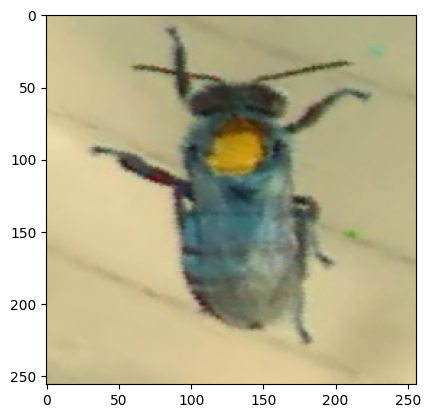

In [4]:
import matplotlib.pyplot as plt
image = images[20]

plt.imshow(image)
plt.show()

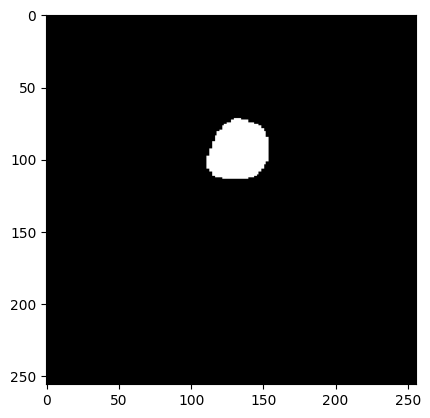

In [5]:
#check mask preprocessing

mask = masks[20]
# Display the mask
plt.imshow(mask, cmap='gray')
plt.show()

In [6]:

### defining model

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(shape=input_size)
    #print(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs=inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)
        
    return model


model = unet() #define model



2023-04-19 11:43:05.771366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 11:43:05.771638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lqmeyers/anaconda3/envs/DLC/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-19 11:43:05.771807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lqmeyers/anaconda3/envs/DLC/lib/python3.8/site-packages/cv2/../../lib64:
2023-04-19 11:43:05.771896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'l

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # set to the index of the GPU you want to use

from keras import backend as K
import tensorflow as tf

# Configure TensorFlow to use your GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)


# Train model

# Define optimizer and loss function
batch_size = 10 
num_epochs = 10


# Train model
history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=num_epochs,
                    validation_data=(val_images, val_masks))


2023-04-19 11:45:53.142423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-19 11:45:53.142586: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



Epoch 1/10
 1/12 [=>............................] - ETA: 3:56 - loss: 0.8768 - accuracy: 0.1307

KeyboardInterrupt: 

In [ ]:
#check that gpu is good 
import tensorflow as tf
tf.config.list_physical_devices('GPU')

: 

In [ ]:


#Running inference 

## calling preprocess on test data 

image_dir = '/home/lqmeyers/CNN_dev/paintTestData/images/testing'
mask_dir = '/home/lqmeyers/CNN_dev/paintTestData/labels/testing'
image_size = 256
num_classes = 2

# Load and preprocess data
test_images, test_masks = preprocess_data(image_dir, mask_dir, image_size, num_classes)


In [ ]:

#predicting on test data 

# Use the model to make predictions on the test data
predicted_masks = model.predict(test_images)

# Save the predicted masks to disk
np.save("predicted_masks.npy", predicted_masks)